# CV project

Following tutrorial from: https://github.com/mberkay0/image-colorization/tree/main


In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms
import matplotlib.pyplot as plt
from skimage import io,color
#from google.colab import files,drive
import shutil
import os
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import time

cuda


## Data loader

In [2]:
class PairedNumpyDataset(Dataset):
    def __init__(self, gt_paths,img_format="jpg"):
        self.gt_paths = gt_paths  # List of ground truth .npy file paths
        self.img_format = img_format

    def __getitem__(self, index):
        # Load ground truth image from .npy file
        if self.img_format == "npy":
            gt_img = np.load(self.gt_paths[index])  # Shape: (N, M, 3)
            gt_img = np.transpose(gt_img, (2, 0, 1))  # Convert to (3, N, M)
            gt_img = torch.from_numpy(gt_img).float()
        else:
            gt_img = io.imread(self.gt_paths[index])
            gt_img = color.rgb2lab(gt_img)
            gt_img = norm_lab_img(gt_img)
            gt_img = np.transpose(gt_img, (2, 0, 1))
            gt_img = torch.from_numpy(gt_img).float()


        L = gt_img[0].unsqueeze(0)
        ab = gt_img[1:]

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.gt_paths)

def files_names_list(N,start_index,gt_path,prefix="lab",suffix=".npy"):
    gt_name_list = []
    for i in range(start_index,start_index+N):
        im_num = i+1
        gt_name_list.append(gt_path+"/"+prefix+str(im_num)+suffix)

    return gt_name_list

In [3]:
"""
# Example Usage
input_paths, gt_paths = files_names_list(5,"datatreatment/input_gray_test","datatreatment/gt_lab_test")


dataset = PairedNumpyDataset(input_paths, gt_paths)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)  # Load in batches

# Iterate through the DataLoader
for batch in dataloader:
    input_batch, gt_batch = batch
    print(f"Input batch shape: {input_batch.shape}")  # (batch_size, 1, N, M)
    print(f"GT batch shape: {gt_batch.shape}")  # (batch_size, 3, N, M)
"""

'\n# Example Usage\ninput_paths, gt_paths = files_names_list(5,"datatreatment/input_gray_test","datatreatment/gt_lab_test")\n\n\ndataset = PairedNumpyDataset(input_paths, gt_paths)\ndataloader = DataLoader(dataset, batch_size=5, shuffle=True)  # Load in batches\n\n# Iterate through the DataLoader\nfor batch in dataloader:\n    input_batch, gt_batch = batch\n    print(f"Input batch shape: {input_batch.shape}")  # (batch_size, 1, N, M)\n    print(f"GT batch shape: {gt_batch.shape}")  # (batch_size, 3, N, M)\n'

## Generator (Unet)

In [4]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

## Discriminator

In [5]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## GAN loss

In [6]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## Model initialization

In [7]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

## Main model

In [8]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, net_D=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        if net_D is None: # new code
            self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        else:
            self.net_D = net_D.to(self.device) # input a pretrained patch discriminator, (not tested)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

## Utility functions

In [9]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def torch_to_numpy(img_tensor):
    """
    Converts a PyTorch image tensor (C, H, W) to a NumPy array (H, W, C).

    Args:
        img_tensor (torch.Tensor): Input tensor with shape (C, H, W).

    Returns:
        np.ndarray: Converted NumPy array with shape (H, W, C).
    """
    if not isinstance(img_tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor")

    if img_tensor.ndim != 3:
        raise ValueError("Expected a 3D tensor (C, H, W), but got shape {}".format(img_tensor.shape))

    img_numpy = img_tensor.permute(1, 2, 0).cpu().numpy()  # Change (C, H, W) -> (H, W, C)
    return img_numpy


def lab_to_rgb(L, ab):
    # Takes a batch of images

    L = (L + 1.) * 50.
    ab = ab * 110.

    if np.any(L.cpu().numpy() < 0) or np.any(L.cpu().numpy() > 100):
      print(f"Invalid L range [0-100]. Detected range: {L.min():.2f}-{L.max():.2f}")

    # For ab channels (should be -128 to 127)
    ab_min = ab.cpu().numpy().min()
    ab_max = ab.cpu().numpy().max()
    if ab_min < -128 or ab_max > 127:
      print(f"Invalid ab range [-128-127]. Detected range: {ab_min:.2f}-{ab_max:.2f}")

    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = color.lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
"""


def lab_to_rgb(L, ab):

    # Takes a batch of images


    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_un = unnorm_lab_img(img)
        img_rgb = color.lab2rgb(img_un)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

"""

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
"""
def visualize(model, data, save=True, num_images=5):
    model.net_G.eval()
    with torch.no_grad():
        # Process the entire batch at once
        model.setup_input(data)
        model.forward()

    # Get all outputs from the single batch
    fake_color = model.fake_color.detach().cpu()
    real_color = model.ab.cpu()
    L = model.L.cpu()

    # Convert all images in the batch
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    # Determine how many images to display (up to batch size)
    batch_size = L.shape[0]
    display_num = min(num_images, batch_size)

    # Create a consistent visualization grid
    fig, axs = plt.subplots(3, display_num, figsize=(15, 8))
    if display_num == 1:  # Handle single image case
        axs = axs[:, np.newaxis]

    titles = ['Input (L)', 'Generated (ab)', 'Ground Truth (ab)']
    for row in range(3):
        for col in range(display_num):
            ax = axs[row, col]
            if row == 0:
                ax.imshow(L[col][0], cmap='gray')
            elif row == 1:
                ax.imshow(fake_imgs[col])
            else:
                ax.imshow(real_imgs[col])
            ax.axis('off')
            if col == 0:
                ax.set_title(titles[row])

    plt.tight_layout()

    if save:
        fig.savefig(f"colorization_{time.time()}.png")
    plt.show()
    model.net_G.train()
"""

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


def norm_lab_img(lab_img):
    """Convert LAB image to normalized range [-1,1]."""
    lab_img[:, :, 0] = (lab_img[:, :, 0] - 0) / (100 - 0) * 2 - 1  # Scale L from [0,100] → [-1,1]
    lab_img[:, :, 1] = (lab_img[:, :, 1] + 128) / (127 + 128) * 2 - 1  # Scale a from [-128,127] → [-1,1]
    lab_img[:, :, 2] = (lab_img[:, :, 2] + 128) / (127 + 128) * 2 - 1  # Scale b from [-128,127] → [-1,1]

    return lab_img

def unnorm_lab_img(normalized_lab_img):
    """Convert LAB image from [-1,1] range back to original LAB range."""
    normalized_lab_img[:, :, 0] = ((normalized_lab_img[:, :, 0] + 1) / 2) * 100  # Convert L from [-1,1] → [0,100]
    normalized_lab_img[:, :, 1] = ((normalized_lab_img[:, :, 1] + 1) / 2) * (127 + 128) - 128  # Convert a from [-1,1] → [-128,127]
    normalized_lab_img[:, :, 2] = ((normalized_lab_img[:, :, 2] + 1) / 2) * (127 + 128) - 128  # Convert b from [-1,1] → [-128,127]

    return normalized_lab_img

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

## Trianing func

In [10]:
def train_model(model, train_dl, epochs, display_every=200):
    #data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs


https://www.vision.caltech.edu/datasets/caltech_10k_webfaces/ data

## upload to temporary memory

In [11]:
"""
# First upload files to Colab
uploaded = files.upload()  # Select your files in the dialog
"""

'\n# First upload files to Colab\nuploaded = files.upload()  # Select your files in the dialog\n'

In [12]:
"""
# Create paths for uploaded files (modify this based on your actual filenames)
gt_path = "/content"  # Colab's root directory for uploaded files
file_list = [os.path.join(gt_path, f) for f in uploaded.keys()]
"""

'\n# Create paths for uploaded files (modify this based on your actual filenames)\ngt_path = "/content"  # Colab\'s root directory for uploaded files\nfile_list = [os.path.join(gt_path, f) for f in uploaded.keys()]\n'

## load from temp storage

In [13]:
"""
# First get list of uploaded files
content_dir = '/content'
file_list = [os.path.join(content_dir, f)
            for f in os.listdir(content_dir)
            if os.path.isfile(os.path.join(content_dir, f))]

# Filter for specific file types if needed
npy_files = [f for f in file_list if f.endswith('.npy')]
image_files = [f for f in file_list if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
"""

"\n# First get list of uploaded files\ncontent_dir = '/content'\nfile_list = [os.path.join(content_dir, f)\n            for f in os.listdir(content_dir)\n            if os.path.isfile(os.path.join(content_dir, f))]\n\n# Filter for specific file types if needed\nnpy_files = [f for f in file_list if f.endswith('.npy')]\nimage_files = [f for f in file_list if f.lower().endswith(('.jpg', '.jpeg', '.png'))]\n"

## upload to drive

In [14]:
"""
# Mount Google Drive
drive.mount('/content/drive') # just run once per session i think

# Define a folder in Google Drive to save the files (e.g., "MyData")
drive_data_dir = "/content/drive/MyDrive/MyDataLab3"
os.makedirs(drive_data_dir, exist_ok=True)  # Create folder if it doesn't exist

for filename in uploaded.keys():
    src_path = f"/content/{filename}"
    dst_path = f"{drive_data_dir}/{filename}"
    shutil.move(src_path, dst_path)  # Use shutil instead of os.rename

print("Files saved to Google Drive:", os.listdir(drive_data_dir))
"""

'\n# Mount Google Drive\ndrive.mount(\'/content/drive\') # just run once per session i think\n\n# Define a folder in Google Drive to save the files (e.g., "MyData")\ndrive_data_dir = "/content/drive/MyDrive/MyDataLab3"\nos.makedirs(drive_data_dir, exist_ok=True)  # Create folder if it doesn\'t exist\n\nfor filename in uploaded.keys():\n    src_path = f"/content/{filename}"\n    dst_path = f"{drive_data_dir}/{filename}"\n    shutil.move(src_path, dst_path)  # Use shutil instead of os.rename\n\nprint("Files saved to Google Drive:", os.listdir(drive_data_dir))\n'

## Load from drive

In [15]:

# Mount Google Drive
#drive.mount('/content/drive') # once per seesion

# Define the path to your saved files
drive_data_dir = "/content/drive/MyDrive/MyDataLab3"

# Load files from Google Drive (no re-upload needed!)
file_list = [os.path.join(drive_data_dir, f) for f in os.listdir(drive_data_dir)]
print("Files loaded from Google Drive:", file_list)


NameError: name 'drive' is not defined

In [ ]:
train = PairedNumpyDataset(file_list[:len(file_list)-16])
val = PairedNumpyDataset(file_list[len(file_list)-16:])
print(len(train),len(val))

t_dataloader = DataLoader(train, batch_size=16, num_workers=4, pin_memory=True, shuffle=True)
v_dataloader = DataLoader(val, batch_size=16, num_workers=4, pin_memory=True, shuffle=False) # so we can see the same images

2132 16


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Training

In [ ]:
#model = MainModel()
#train_model(model, t_dataloader, 20) # ca 30 min with T4

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

## save trained model

In [ ]:
"""
# Save to Colab's temporary storage (will be lost when session ends)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizerG_state_dict': model.opt_G.state_dict(),
    'optimizerD_state_dict': model.opt_D.state_dict(),
}, '/content/colorization_model.pth')
"""

# Optional: Save to Google Drive for persistence
#from google.colab import drive
# drive.mount('/content/drive')
time_stamp = time.strftime("%Y%m%d-%H%M%S")
# Save to Drive
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizerG_state_dict': model.opt_G.state_dict(),
    'optimizerD_state_dict': model.opt_D.state_dict(),
}, f'/content/drive/MyDrive/ColorationModels/colorization_model_{time_stamp}.pth')


## Load trained model

In [ ]:
list_files("/content/drive/MyDrive/ColorationModels")

ColorationModels/
    colorization_model.pth
    res18-unet.pt
    colorization_full_model_20250319-101930.pt
    colorization_model_20250320-104847.pth


In [ ]:

# Initialize a new model instance
loaded_model = MainModel()

# Load from Colab's temporary storage
# checkpoint = torch.load('/content/colorization_model.pth')

# Or load from Google Drive
#drive.mount('/content/drive')
timestamp = "20250320-104847"
checkpoint = torch.load(f'/content/drive/MyDrive/ColorationModels/colorization_model_{timestamp}.pth')#,map_location=torch.device('cpu')) # if only on cpu
#checkpoint = torch.load(f'/content/drive/MyDrive/ColorationModels/colorization_model.pth',map_location=torch.device('cpu')) # if on cpu

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.opt_G.load_state_dict(checkpoint['optimizerG_state_dict'])
loaded_model.opt_D.load_state_dict(checkpoint['optimizerD_state_dict'])

# Set to evaluation mode
loaded_model.eval()

model initialized with norm initialization
model initialized with norm initialization


MainModel(
  (net_G): Unet(
    (model): UnetBlock(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace=True)
            (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace=True)
                (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): UnetBlock(
                  (model): Sequential(
                    (0): LeakyReLU(negative_slope=0.2, inplace=True)
                    (1): Conv2d(256, 512, kernel_s

In [ ]:
"""# Test with random input
test_input = torch.randn(1, 1, 256, 256).to(loaded_model.device)
with torch.no_grad():
    output = loaded_model.net_G(test_input)
print(f"Output shape: {output.shape}")  # Should be (1, 2, 256, 256)"""

## view a test inference

<ipython-input-8-d30bc98f6251>:71: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = color.lab2rgb(img)


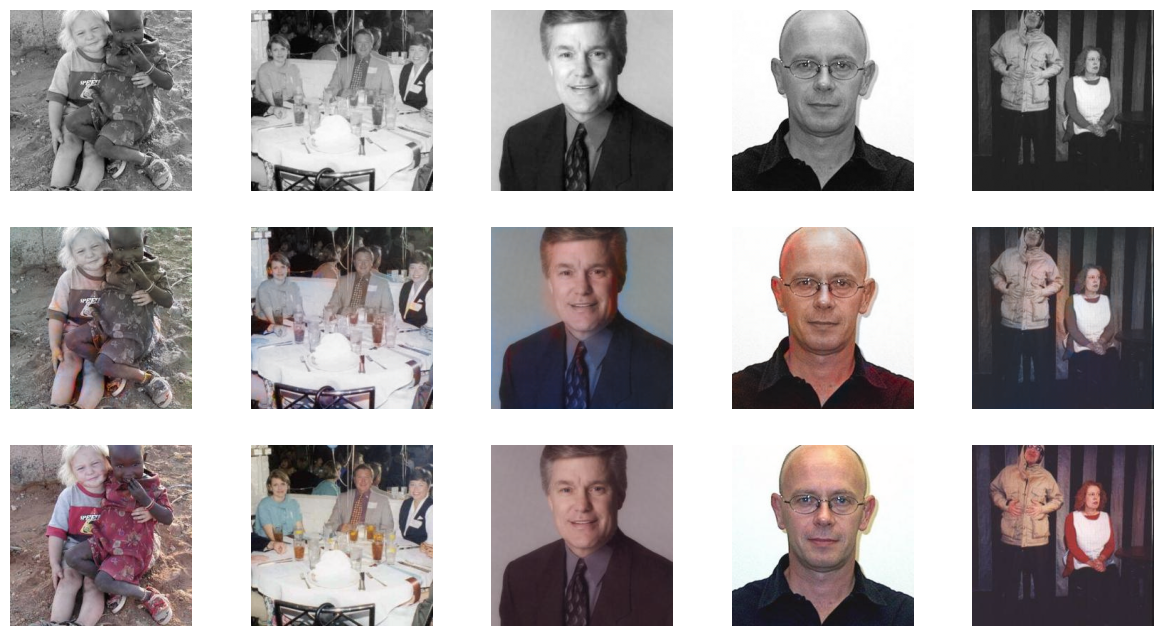

In [ ]:
test_data = next(iter(v_dataloader)) # defined without shuffle above for easy compare
visualize(loaded_model, test_data, save=True) # not the same image processing as the model was trained on

## Part two, pretrained generator

In [ ]:
# pip install fastai #==2.4

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:

def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

## Pretraining generator

In [ ]:

def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)



In [ ]:
#opt = optim.Adam(net_G.parameters(), lr=1e-4)
#criterion = nn.L1Loss()
#pretrain_generator(net_G, t_dataloader, opt, criterion, 20) # ca 30 min
# # Save to Drive
#time_stamp = time.strftime("%Y%m%d-%H%M%S")
#torch.save(net_G.state_dict(), f"/content/drive/MyDrive/ColorationModels/res18-unet_{time_stamp}.pt")

  0%|          | 0/134 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20
L1 Loss: 0.07465


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.06890


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.06779


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.06725


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.06657


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.06584


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.06555


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.06457


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.06351


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.06241


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.06107


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.05943


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.05829


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.05772


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.05626


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.05496


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.05388


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.05260


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.05075


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.04992


## putting together with discriminator

In [ ]:
list_files("/content/drive/MyDrive/ColorationModels")

ColorationModels/
    colorization_model.pth
    res18-unet.pt
    colorization_full_model_20250319-101930.pt
    colorization_model_20250320-104847.pth
    res18-unet_20250320-111804.pt


In [ ]:
net_G_load = build_res_unet(n_input=1, n_output=2, size=256)
timestamp = "20250320-111804"
net_G_load.load_state_dict(torch.load(f"/content/drive/MyDrive/ColorationModels/res18-unet_{timestamp}.pt", map_location=device))

<All keys matched successfully>

In [ ]:
full_model = MainModel(net_G=net_G_load) # net_G
train_model(full_model, t_dataloader, 20) # 40 min,.. maaaaaaan, lost GPU on last iteration and the progress wasnt saved, have one full model saved though

model initialized with norm initialization


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

## test visualise, same data as above test for other model

In [ ]:
visualize(full_model, test_data, save=True)

## save model

In [ ]:
def save_full_model(model, save_path, drive_mount=True):
    """Save complete model state to disk"""
    if drive_mount:
        drive.mount('/content/drive', force_remount=True)

    # Save checkpoints with timestamps
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    full_save_path = f"{save_path}/colorization_full_model_{timestamp}.pt"

    torch.save({
        'generator_state': model.net_G.state_dict(),
        'discriminator_state': model.net_D.state_dict(),
        'optimizerG_state': model.opt_G.state_dict(),
        'optimizerD_state': model.opt_D.state_dict(),
        'model_params': {
            'lambda_L1': model.lambda_L1,
            'device': model.device
        }
    }, full_save_path)

    print(f"Model saved to {full_save_path}")
    return full_save_path

In [ ]:

# After training (assuming model is your trained MainModel instance):
# Save to Google Drive (persistent)
drive_path = "/content/drive/MyDrive/ColorationModels"
model_save_path = save_full_model(full_model, drive_path)

# Or save to Colab temporary storage
# temp_save_path = save_full_model(model, "/content", drive_mount=False)

NameError: name 'full_model' is not defined

## load model

In [ ]:
def load_full_model(save_path, map_location=None):
    """Load complete model state from disk"""
    if map_location is None:
        map_location = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint = torch.load(save_path, map_location=map_location)

    # Rebuild model architecture
    net_G = build_res_unet(n_input=1, n_output=2, size=256)
    model = MainModel(net_G=net_G)

    # Load states
    model.net_G.load_state_dict(checkpoint['generator_state'])
    model.net_D.load_state_dict(checkpoint['discriminator_state'])
    model.opt_G.load_state_dict(checkpoint['optimizerG_state'])
    model.opt_D.load_state_dict(checkpoint['optimizerD_state'])

    # Load parameters
    model.lambda_L1 = checkpoint['model_params']['lambda_L1']
    model.device = checkpoint['model_params']['device']
    model.to(model.device)

    return model

In [ ]:

list_files("/content/drive/MyDrive/ColorationModels")

In [ ]:
# To load later:
time_stamp = "20250319-101930"
model_save_path = f"/content/drive/MyDrive/ColorationModels/colorization_full_model_{time_stamp}.pt"
loaded_full_model = load_full_model(model_save_path)

In [ ]:
# Verify loading works
#test_input = next(iter(v_dataloader))
# visualize(full_model, test_data, save=True)
visualize(loaded_full_model, test_data, save=True)

## Todo
Try what is suggested in https://github.com/jantic/DeOldify

see under section: what is noGAN?

pretrain the discriminator as well, then train full GAN together. See if we also get good results after little training together. Can we think of something for predicting the inflection point maybe.

comment: newest model in drive are with Lab3 data